In [2]:
#!pip install --upgrade transformers
#!pip install --upgrade datasets

## 1. Unsupervised/DA FT

### Training

In [8]:
from transformers import AutoModelForMaskedLM, DataCollatorForLanguageModeling
from transformers import AutoTokenizer,Trainer, TrainingArguments

In [12]:
corpus = ["Artificial intelligence is transforming industries", 
          "Cloud computing offers scalable storage solutions", 
          "5G enables faster mobile connectivity", 
          "Blockchain ensures secure digital transactions", 
          "Quantum computing is the future", 
          "IoT connects smart devices globally", 
          "Cybersecurity protects sensitive data online", 
          "Virtual reality creates immersive experiences", 
          "Machine learning automates decision-making", 
          "Data science drives business insights"]

from datasets import Dataset
text_dataset = Dataset.from_dict({"text": corpus})
text_dataset

Dataset({
    features: ['text'],
    num_rows: 10
})

In [14]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [20]:
def tokenize_corpus(sample):
    return tokenizer(sample["text"], truncation=True, padding="max_length", max_length=64)

In [21]:
tokenizer_corpus = text_dataset.map(tokenize_corpus)
tokenizer_corpus

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 10
})

In [25]:
args = TrainingArguments(output_dir="C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/results",
                        per_device_eval_batch_size=8,
                        num_train_epochs=3,
                        logging_strategy="no",
                        save_strategy="no",
                        report_to="none"
                        )

In [26]:
trainer = Trainer(model=model,
                 args=args,
                 train_dataset=tokenizer_corpus,
                 data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer,mlm=True))

In [27]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=6, training_loss=3.4830859502156577, metrics={'train_runtime': 10.9336, 'train_samples_per_second': 2.744, 'train_steps_per_second': 0.549, 'total_flos': 497104335360.0, 'train_loss': 3.4830859502156577, 'epoch': 3.0})

In [28]:
#functions
#.train()
#.evaluate()
#.predict()
#.save_model()

In [29]:
#Save the model and read from local
save_path="C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models\\tokenizer_config.json',
 'C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models\\special_tokens_map.json',
 'C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models\\vocab.txt',
 'C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models\\added_tokens.json',
 'C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models\\tokenizer.json')

### From Local

In [3]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
load_path="C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models"
model= AutoModelForMaskedLM.from_pretrained(load_path)
tokenizer= AutoTokenizer.from_pretrained(load_path)

In [9]:
import torch
text = "Virtual reality creates immersive [MASK]."
inputs = tokenizer(text,return_tensors="pt")
inputs

{'input_ids': tensor([[  101,  7484,  4507,  9005, 10047, 16862,  3512,   103,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [10]:
if tokenizer.mask_token_id not in inputs["input_ids"]:
    raise ValueError("No [Mask]")

In [19]:
with torch.no_grad():
    output = model(**inputs)
    logits = output.logits

mask_token_index = torch.where(inputs["input_ids"]==tokenizer.mask_token_id)[1]
top_k =5
mask_logits = logits[0, mask_token_index, :]
top_tokens = torch.topk(mask_logits,top_k,dim=1).indices[0].tolist()

for token_id in top_tokens:
    print(tokenizer.decode([token_id]))

environments
spaces
experiences
imagery
images


## 2. Supervised FT

### Training

In [20]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [28]:
# 1. Load IMDB dataset
dataset = load_dataset("imdb")

train_dataset = dataset["train"].shuffle(seed=42).select(range(200))
test_dataset = dataset["test"].shuffle(seed=42).select(range(50))

In [29]:
df = test_dataset.to_pandas()
df.head(2)

,text,label
0,<br /><br />When I unsuspectedly rented A Thou...,1
1,This is the latest entry in the long series of...,1


In [30]:
# 2. Load tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3. Load model for classification (num_labels=2 for binary)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# 4. Tokenize dataset
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [32]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [35]:
# 5. Create Trainer
args = TrainingArguments(output_dir="C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/results",
                        per_device_eval_batch_size=8,
                        num_train_epochs=3,
                        logging_strategy="no",
                        save_strategy="no",
                        report_to="none",
                        metric_for_best_model="accuracy",
                        )



trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 8. Train the model
trainer.train()

C:\Users\Abhishek Jaiswal\AppData\Local\Temp\ipykernel_2148\2293223536.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=75, training_loss=0.3892241668701172, metrics={'train_runtime': 449.7589, 'train_samples_per_second': 1.334, 'train_steps_per_second': 0.167, 'total_flos': 39740219596800.0, 'train_loss': 0.3892241668701172, 'epoch': 3.0})

In [36]:
# 6. Evaluate the model
results = trainer.evaluate()
print("Test Results:", results)

Test Results: {'eval_loss': 0.45462727546691895, 'eval_accuracy': 0.78, 'eval_f1': 0.7843137254901961, 'eval_precision': 0.6896551724137931, 'eval_recall': 0.9090909090909091, 'eval_runtime': 9.7303, 'eval_samples_per_second': 5.139, 'eval_steps_per_second': 0.719, 'epoch': 3.0}


In [37]:
#Save the model and read from local
save_path="C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models2"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models2\\tokenizer_config.json',
 'C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models2\\special_tokens_map.json',
 'C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models2\\vocab.txt',
 'C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models2\\added_tokens.json',
 'C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models2\\tokenizer.json')

### From Local

In [38]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the fine-tuned model and tokenizer
model_path = "C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models2"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Put model in evaluation mode
model.eval()

# Example input
text = "The movie was absolutely wonderful, I loved every moment of it!"

# Tokenize the input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()

# Map prediction to label
label_map = {0: "Negative", 1: "Positive"}

print(f"Text: {text}")
print(f"Predicted Sentiment: {label_map[predicted_class_id]}")

Text: The movie was absolutely wonderful, I loved every moment of it!
Predicted Sentiment: Positive


In [50]:
from datasets import Dataset
predict_dataset = Dataset.from_dict({"text":"moviee was fine fine"})
predict_dataset = predict_dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding=True),batched=True)
predict_dataset = predict_dataset.remove_columns(["text"])
predictions=trainer.predict(predict_dataset)
predictions.predictions.argmax(axis=-1)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## 3. Instruction Based FT

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import Trainer, TrainingArguments

In [10]:
#Prepare Dataset
from datasets import Dataset

data = {
    "instruction": ["Translate to French"] * 20,
    "input": [
        "Good morning, how are you?",
        "Thank you for your help.",
        "I would like a cup of coffee.",
        "This is my favorite book.",
        "Can you please repeat that?",
        "The weather is nice today.",
        "Where is the nearest train station?",
        "I love learning new languages.",
        "Please bring me the menu.",
        "What time is the meeting?",
        "I am going to the supermarket.",
        "My phone battery is low.",
        "We had a great time yesterday.",
        "She is an excellent teacher.",
        "I need to buy a gift.",
        "Do you speak English?",
        "How much does this cost?",
        "I am feeling very tired.",
        "Let's go to the park.",
        "The flight is delayed by an hour."
    ],
    "output": [
        "Bonjour, comment ça va ?",
        "Merci pour votre aide.",
        "Je voudrais une tasse de café.",
        "C'est mon livre préféré.",
        "Pouvez-vous répéter, s'il vous plaît ?",
        "Il fait beau aujourd'hui.",
        "Où est la gare la plus proche ?",
        "J'aime apprendre de nouvelles langues.",
        "Apportez-moi le menu, s'il vous plaît.",
        "À quelle heure est la réunion ?",
        "Je vais au supermarché.",
        "La batterie de mon téléphone est faible.",
        "Nous avons passé un bon moment hier.",
        "Elle est une excellente enseignante.",
        "Je dois acheter un cadeau.",
        "Parlez-vous anglais ?",
        "Combien cela coûte-t-il ?",
        "Je me sens très fatigué.",
        "Allons au parc.",
        "Le vol a une heure de retard."
    ]
}


train_dataset = Dataset.from_dict(data)
train_dataset

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 20
})

In [11]:
#Format Dataset for T5
def format_instruction(example):
    return {
        "text": f"{example['instruction']}: {example['input']}",
        "labels": example["output"]
    }

formatted_dataset = train_dataset.map(format_instruction)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [13]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [14]:
#Tokenize Dataset
# Assuming this is your tokenization function
def tokenize(example):
    model_input = tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)
    labels = tokenizer(example["labels"], truncation=True, padding="max_length", max_length=64)
    model_input["labels"] = labels["input_ids"]
    return model_input

# Apply tokenizer
tokenized_dataset = formatted_dataset.map(tokenize, remove_columns=formatted_dataset.column_names)

# Set tensor format (VERY IMPORTANT)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [15]:
#TrainingArguments + Trainer
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/results",  # Directory to save model checkpoints
    overwrite_output_dir=True,             # Overwrite existing files
    per_device_train_batch_size=4,
    num_train_epochs=5,
    learning_rate=3e-4,
    weight_decay=0.01,
    
    logging_dir="C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/logs",  # Logging dir
    logging_steps=10,
    
    save_steps=50,
    save_total_limit=1,
    
    report_to="none",                      # Disable wandb/tensorboard unless using them
    remove_unused_columns=False            # Needed for custom inputs like instruction-format
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
)

C:\Users\Abhishek Jaiswal\AppData\Local\Temp\ipykernel_11192\604609242.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
#Train
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
10,4.546000
20,0.977800


TrainOutput(global_step=25, training_loss=2.3481567192077635, metrics={'train_runtime': 68.5573, 'train_samples_per_second': 1.459, 'train_steps_per_second': 0.365, 'total_flos': 6767090073600.0, 'train_loss': 2.3481567192077635, 'epoch': 5.0})

In [17]:
import torch

# Make prediction
instruction = "Translate to French"
input_text = "The weather is very pleasant today."

# Combine instruction and input like during training
input_combined = f"{instruction}: {input_text}"

# Tokenize
input_ids = tokenizer(input_combined, return_tensors="pt", truncation=True, padding=True).input_ids

# Generate prediction
with torch.no_grad():
    generated_ids = model.generate(input_ids, max_length=50)
    result = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Output
print("Input Text:", input_text)
print("Generated French Translation:", result)

Input Text: The weather is very pleasant today.
Generated French Translation: 


In [18]:
# Save the model and tokenizer locally
pathh= "C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models3"
model.save_pretrained(pathh)
tokenizer.save_pretrained(pathh)

('C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models3\\tokenizer_config.json',
 'C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models3\\special_tokens_map.json',
 'C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models3\\tokenizer.json')

### local

In [1]:
#Load the model and tokenizer later (for inference)
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
pathh= "C:/Users/Abhishek Jaiswal/GenAI/LLM_FT/Models3"
# Load saved model
model = AutoModelForSeq2SeqLM.from_pretrained(pathh)
tokenizer = AutoTokenizer.from_pretrained(pathh)
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [2]:
import torch

# 🔹 Step 1: Define instruction and input
instruction = "Translate to French"
input_text = "The weather is very pleasant today."

# 🔹 Step 2: Combine instruction and input
input_combined = f"{instruction}: {input_text}"

# 🔹 Step 3: Tokenize input
inputs = tokenizer(
    input_combined,
    return_tensors="pt",
    truncation=True,
    padding="max_length",
    max_length=256
)

# 🔹 Step 4: Generate output from model
with torch.no_grad():
    generated_ids = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=50,
        num_beams=4,              # Better quality with beam search
        early_stopping=True,
        no_repeat_ngram_size=2    # Avoid repetition
    )

# 🔹 Step 5: Decode the generated tokens to readable text
prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# 🔹 Step 6: Print result
print("Input Text:", input_text)
print("Generated French Translation:", prediction)

Input Text: The weather is very pleasant today.
Generated French Translation: La météo est très agréable aujourd'hui, et elle est particulièrement agréable.


## 4. Reinforcement Learning with Human Feedback (RLHF)

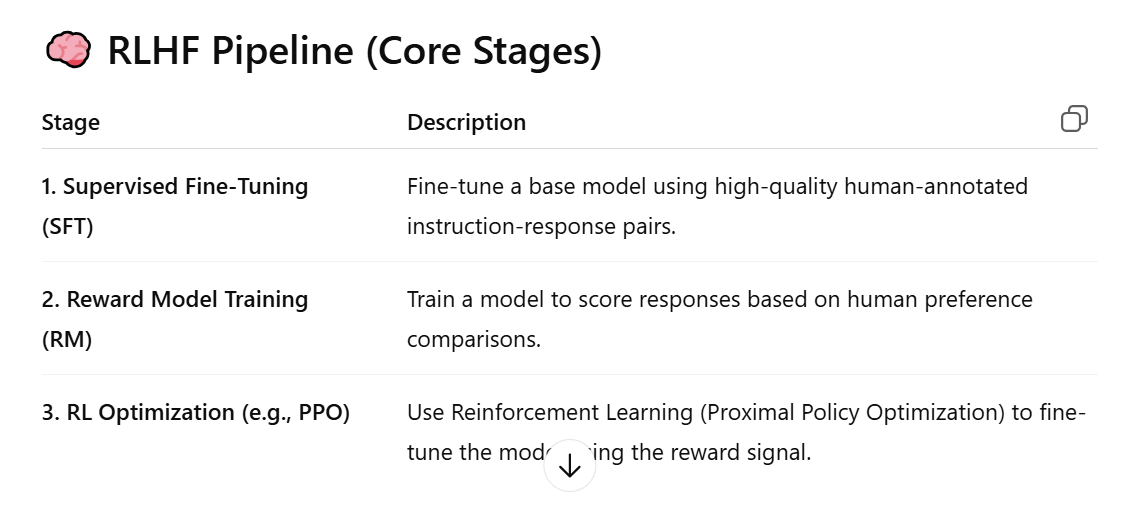

### 1. Supervised Fine-Tuning (SFT) — Instruction Tuning

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

def tokenize_fn(example):
    return tokenizer(example["prompt"] + example["response"], truncation=True, padding="max_length", max_length=512)

dataset = load_dataset("yizhongw/self_instruct", split="train[:1000]")
dataset = dataset.map(tokenize_fn)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./sft",
        per_device_train_batch_size=4,
        num_train_epochs=3,
        logging_dir="./logs"
    ),
    train_dataset=dataset
)

trainer.train()

### 2. Reward Model (RM) Training — Learn from Comparisons

In [ ]:
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset

# Assume your dataset has {"prompt", "chosen", "rejected"}
dataset = load_dataset("lvwerra/stack-exchange-paired")

def preprocess(example):
    return {
        "text_chosen": example["prompt"] + example["chosen"],
        "text_rejected": example["prompt"] + example["rejected"]
    }

dataset = dataset.map(preprocess)

# Use a reward model (e.g., 1 output head)
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=1)

# Use TRL or custom pairwise loss (e.g., cross-entropy between chosen > rejected)
# You can use `trl.RewardTrainer` to simplify reward modeling

### 3. Reinforcement Learning Optimization — PPO (Proximal Policy Optimization)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from datasets import load_dataset

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLMWithValueHead.from_pretrained("gpt2")

# PPO Config
ppo_config = PPOConfig(batch_size=4, log_with=None)

# Load data
dataset = load_dataset("Dahoas/synthetic-instruct-gptj-pairwise", split="train[:1000]")

def format_prompt(example):
    return tokenizer(example["prompt"], return_tensors="pt").input_ids

# Dummy reward function (replace with real reward model)
def reward_fn(prompts, responses):
    return torch.tensor([1.0 for _ in responses])  # Dummy constant reward

ppo_trainer = PPOTrainer(
    config=ppo_config,
    model=model,
    tokenizer=tokenizer,
    dataset=dataset,
    reward_fn=reward_fn
)

# Training loop
ppo_trainer.train()


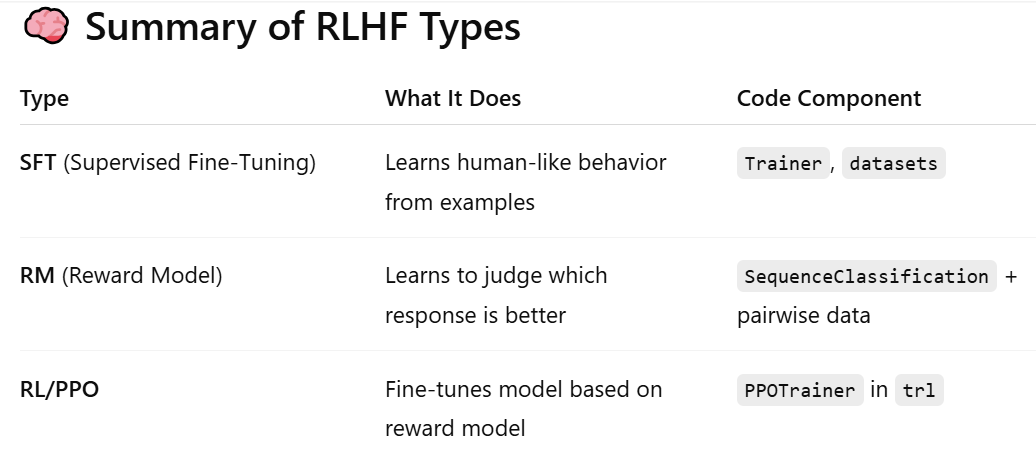